## **Setup**

In [1]:
import os
import random
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, roc_curve, auc
from matplotlib.colors import LinearSegmentedColormap
from termcolor import colored

# Set seed for reproducibility of results
seed_value = 0
os.environ['PYTHONHASHSEED']=str(seed_value)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

tf.compat.v1.reset_default_graph()

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)

# Configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

tf.__version__

'2.3.0'

In [2]:
from google.colab import drive
mount_path = '/content/gdrive/'
drive.mount(mount_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [3]:
# Set and test path to competition data files
competition_path = 'My Drive/Final Project ITC/MAFAT Challenge/Data'
try:
  if competition_path == 'INSERT HERE':
    print('Please enter path to competition data files:')
    competition_path = input()
  file_path = 'MAFAT RADAR Challenge - Training Set V1.csv'
  with open(f'{mount_path}/{competition_path}/{file_path}') as f:
    f.readlines()
  print(colored('Everything is setup correctly', color='green'))
except:
  print(colored('Please mount drive and set competition_path correctly',
                color='red'))

Everything is setup correctly


## **Functions**

All functions will be used in the "Training the Model" section.

### **Data loading**

In [4]:
# Functions for loading the data
def load_data(file_path):
  """
  Reads all data files (metadata and signal matrix data) as python dictionary,
  the pkl and csv files must have the same file name.

  Arguments:
    file_path -- {str} -- path to the iq_matrix file and metadata file

  Returns:
    Python dictionary
  """
  pkl = load_pkl_data(file_path)
  meta = load_csv_metadata(file_path)
  data_dictionary = {**meta, **pkl}
  
  for key in data_dictionary.keys():
    data_dictionary[key] = np.array(data_dictionary[key])

  return data_dictionary


def load_pkl_data(file_path):
  """
  Reads pickle file as a python dictionary (only Signal data).

  Arguments:
    file_path -- {str} -- path to pickle iq_matrix file

  Returns:
    Python dictionary
  """
  path = os.path.join(mount_path, competition_path, file_path + '.pkl')
  with open(path, 'rb') as data:
    output = pickle.load(data)
  return output


def load_csv_metadata(file_path):
  """
  Reads csv as pandas DataFrame (only Metadata).

  Arguments:
    file_path -- {str} -- path to csv metadata file

  Returns:
    Pandas DataFarme
  """
  path = os.path.join(mount_path, competition_path, file_path + '.csv')
  with open(path, 'rb') as data:
    output = pd.read_csv(data)
  return output

## **Data Preprocessing**  
   



In [5]:
# Functions for preprocessing and preprocess function
def fft(iq, axis=0):
  """
  Computes the log of discrete Fourier Transform (DFT).
     
  Arguments:
    iq_burst -- {ndarray} -- 'iq_sweep_burst' array
    axis -- {int} -- axis to perform fft in (Default = 0)

  Returns:
    log of DFT on iq_burst array
  """
  iq = np.log(np.abs(np.fft.fft(hann(iq), axis=axis)))
  return iq


def hann(iq, window=None):
    """
    Preformes Hann smoothing of 'iq_sweep_burst'.

    Arguments:
      iq {ndarray} -- 'iq_sweep_burst' array
      window -{range} -- range of hann window indices (Default=None)
               if None the whole column is taken

    Returns:
      Regulazied iq in shape - (window[1] - window[0] - 2, iq.shape[1])
    """
    if window is None:
        window = [0, len(iq)]

    N = window[1] - window[0] - 1
    n = np.arange(window[0], window[1])
    n = n.reshape(len(n), 1)
    hannCol = 0.5 * (1 - np.cos(2 * np.pi * (n / N)))
    return (hannCol * iq[window[0]:window[1]])[1:-1]


def max_value_on_doppler(iq, doppler_burst):
  """
  Set max value on I/Q matrix using doppler burst vector. 
     
  Arguments:
    iq_burst -- {ndarray} -- 'iq_sweep_burst' array
    doppler_burst -- {ndarray} -- 'doppler_burst' array (center of mass)
               
  Returns:
    I/Q matrix with the max value instead of the original values
    The doppler burst marks the matrix values to change by max value
  """
  iq_max_value = np.max(iq)
  for i in range(iq.shape[1]):
    if doppler_burst[i]>=len(iq):
       continue
    iq[doppler_burst[i], i] = iq_max_value
  return iq


def normalize(iq):
  """
  Calculates normalized values for iq_sweep_burst matrix:
  (vlaue-mean)/std.
  """
  m = iq.mean()
  s = iq.std()
  return (iq-m)/s


def data_preprocess(data):
  """
  Preforms data preprocessing.
  Change target_type lables from string to integer:
  'human'  --> 1
  'animal' --> 0

  Arguments:
    data -- {ndarray} -- the data set

  Returns:
    processed data (max values by doppler burst, DFT, normalization)
  """
  X=[]
  for i in range(len(data['iq_sweep_burst'])):
    iq = fft(data['iq_sweep_burst'][i])
    iq = max_value_on_doppler(iq,data['doppler_burst'][i])
    iq = normalize(iq)
    X.append(iq)

  data['iq_sweep_burst'] = np.array(X)
  if 'target_type' in data:
    data['target_type'][data['target_type'] == 'animal'] = 0
    data['target_type'][data['target_type'] == 'human'] = 1
  return data

### **Splitting the Training set**

The functions below split the training set into Train and Validation sets.

* Validation Set.   
The validation set is constructed from segments from geolocation_ids 1 and 4.   
These geolocations' target_type distributions are balanced.
To create a fair representation of the test set   
(one segment form each track) every sixth segment was taken to the validation set.   
The reason is that approximately 75% of the tracks have less than 6 segments,   
it guarantees that most of the segments in the validation set are not from the same track.   
   
* Adding "human" segments to the training set.   
The training set is imbalanced.   
One can address this issue by taking segements of humans from the "Auxiliary Experiment Set".   
The first 3 segments from each track are taken into the training set (or less if the track is shorter than 3 segments).

In [6]:
# Function for splitting the data to training and validation
# and function for selecting samples of segments from the Auxiliary dataset
def split_train_val(data):
  """
  Split the data to train and validation set.
  The validation set is built from training set segments of 
  geolocation_id 1 and 4. 
  Use the function only after the training set is complete and preprocessed. 

  Arguments:
    data -- {ndarray} -- the data set to split

  Returns:
    iq_sweep_burst ndarray matrices
    target_type vector 
    for training and validation sets
  """
  idx = ((data['geolocation_id'] == 4) | (data['geolocation_id'] == 1))\
   & (data['segment_id'] % 6 == 0)
  training_x = data['iq_sweep_burst'][np.logical_not(idx)]
  training_y = data['target_type'][np.logical_not(idx)]
  validation_x = data['iq_sweep_burst'][idx]
  validation_y = data['target_type'][idx]
  return training_x, training_y, validation_x, validation_y

def aux_split(data):
  """
  Selects segments from the auxilary set for training set.
  Takes the first 3 segments (or less) from each track.

  Arguments:
    data {dataframe} -- the auxilary data

  Returns:
    The auxilary data for the training
  """
  idx = np.bool_(np.zeros(len(data['track_id'])))
  for track in np.unique(data['track_id']):
    idx |= data['segment_id']==(data['segment_id'][data['track_id'] == track][:3])
  
  for key in data:
    data[key] = data[key][idx]
  return data

## **Model**

In [30]:
import tensorflow as tf
from sklearn.metrics import classification_report
from tensorflow.keras.applications import ResNet50, VGG19, InceptionResNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as inception_resnet_v2_preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### **CNN Model** - transfer learning


In [37]:
# Building the model
def create_model(model_tl, input_shape= (126, 32, 3)):
  """
  Transfer learning Resnet model. trained on imagenet
  The input shape must be RGB, hense we must duplicate the channel 3 times

  Arguments:
    input_shape -- the shape of our input
    init -- the weight initialization

  Returns:
    CNN model - with resnet inside  
  """
  tl_model = Sequential(name="transfer_learning_model")
  tl_model.add(Input(shape=input_shape))
  tl_model.add(model_tl(include_top=False, weights="imagenet", pooling='avg'))
  # tl_model.add(Dense(256,activation=('relu'))) 
  # tl_model.add(Dropout(.2))
  # tl_model.add(Dense(128,activation=('relu')))
  # tl_model.add(Dropout(.2))

  tl_model.add(Dense(1, activation="sigmoid"))

  # Say not to train first layer (ResNet) model. It is already trained
  tl_model.layers[0].trainable = False
  return tl_model

### **Evaluation and Visualization of Model's results**

In [11]:
# Function for calculating the final ROC-AUC score and plot the ROC curve,
# used in the "Results" section
def stats(pred, actual):
  """
  Computes the model ROC-AUC score and plots the ROC curve.

  Arguments:
    pred -- {ndarray} -- model's probability predictions
    actual -- the true lables

  Returns:
    ROC curve graph and ROC-AUC score
  """
  plt.figure(figsize=(20, 10))
  fpr1, tpr1, _ = roc_curve(actual[0], pred[0])
  fpr2, tpr2, _ = roc_curve(actual[1], pred[1])
  roc_auc = [auc(fpr1, tpr1), auc(fpr2, tpr2)]
  lw = 2
  plt.plot(fpr1, tpr1, lw=lw, label='Training set (ROC-AUC = %0.2f)' % roc_auc[0])
  plt.plot(fpr2, tpr2, lw=lw, label='Validation set (ROC-AUC = %0.2f)' % roc_auc[1])
  plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--', label = 'Random guess')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate', fontsize=18)
  plt.ylabel('True Positive Rate', fontsize=18)
  plt.title('Training set vs. Validation set ROC curves')
  plt.legend(loc="lower right", prop = {'size': 20})
  plt.show()

## **Training The Model**

In [12]:
# Loading and preparing the data

# Loading Auxiliary Experiment set - can take a few minutes
experiment_auxiliary = 'MAFAT RADAR Challenge - Auxiliary Experiment Set V2'
experiment_auxiliary_df = load_data(experiment_auxiliary)

In [13]:
# Taking sample from the Auxiliary Experiment set
train_aux = aux_split(experiment_auxiliary_df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [14]:
# The function append_dict is for concatenating the training set 
# with the Auxiliary data set segments

def append_dict(dict1, dict2):
  for key in dict1:
    dict1[key] = np.concatenate([dict1[key], dict2[key]], axis=0)
  return dict1

In [15]:
# Training set
train_path = 'MAFAT RADAR Challenge - Training Set V1'
training_df = load_data(train_path)

# Adding segments from the experiment auxiliary set to the training set
train_df = append_dict(training_df, train_aux)

# Preprocessing and split the data to training and validation
train_df = data_preprocess(train_df.copy())
train_x, train_y, val_x, val_y = split_train_val(train_df)

val_y =  val_y.astype(int)
train_y =train_y.astype(int)

In [16]:
#train_x = train_x.reshape(list(train_x.shape)+[1])

train_x = np.repeat(train_x[...,np.newaxis], 3, -1)

#val_x = val_x.reshape(list(val_x.shape)+[1])

val_x = np.repeat(val_x[...,np.newaxis], 3, -1)


In [17]:
# Public test set - loading and preprocessing
test_path = 'MAFAT RADAR Challenge - Public Test Set V1'
test_df = load_data(test_path)
test_df = data_preprocess(test_df.copy())
test_x = test_df['iq_sweep_burst']
#test_x = test_x.reshape(list(test_x.shape)+[1])

test_x = np.repeat(test_x[...,np.newaxis], 3, -1)


In [23]:
# Model configuration:
batch_size = 16
img_width, img_height = 126, 32
loss_function = BinaryCrossentropy()
no_epochs = 30
optimizer = Adam(learning_rate = 0.001)
#input_shape = (img_width, img_height, 1) 

input_shape = (img_width, img_height, 3)  # must be 3 is RGB for using transfer learning

# callbacks
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

Resnet50

In [38]:
# Creating and running the model
model = create_model(ResNet50, input_shape)  
model.compile(loss=loss_function, optimizer=optimizer, metrics=[AUC(), 'accuracy'])

model.summary()

Model: "transfer_learning_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [39]:
datagen = ImageDataGenerator(preprocessing_function=resnet50_preprocess_input)
train_gen = datagen.flow(train_x, train_y, batch_size=batch_size)

In [40]:
history_resnet50 = model.fit(train_gen,
          steps_per_epoch=len(train_x) // batch_size,
          epochs=no_epochs,
          validation_data=(val_x, val_y),
          validation_steps=len(val_x) // batch_size,
          callbacks=earlystop)
          

Epoch 1/30
410/410 [==============================] - 7s 17ms/step - loss: 0.2648 - auc_3: 0.8962 - accuracy: 0.8904 - val_loss: 3.2182 - val_auc_3: 0.5473 - val_accuracy: 0.5146
Epoch 2/30
410/410 [==============================] - 6s 15ms/step - loss: 0.2276 - auc_3: 0.9280 - accuracy: 0.9049 - val_loss: 4.5446 - val_auc_3: 0.5067 - val_accuracy: 0.5146
Epoch 3/30
410/410 [==============================] - 6s 15ms/step - loss: 0.2197 - auc_3: 0.9344 - accuracy: 0.9084 - val_loss: 5.1725 - val_auc_3: 0.5000 - val_accuracy: 0.5146
Epoch 4/30
410/410 [==============================] - 6s 15ms/step - loss: 0.2121 - auc_3: 0.9392 - accuracy: 0.9115 - val_loss: 5.9490 - val_auc_3: 0.5000 - val_accuracy: 0.5146
Epoch 5/30
410/410 [==============================] - 6s 15ms/step - loss: 0.2073 - auc_3: 0.9422 - accuracy: 0.9130 - val_loss: 6.5987 - val_auc_3: 0.5000 - val_accuracy: 0.5146
Epoch 6/30
410/410 [==============================] - 6s 15ms/step - loss: 0.2038 - auc_3: 0.9451 - accur

VGG19

In [25]:
# Creating and running the model
model = create_model(VGG19, input_shape)  
model.compile(loss=loss_function, optimizer=optimizer, metrics=[AUC(), 'accuracy'])

datagen = ImageDataGenerator(preprocessing_function=vgg19_preprocess_input)
train_gen = datagen.flow(train_x, train_y, batch_size=batch_size)

history_vgg19 = model.fit(train_gen,
          steps_per_epoch=len(train_x) // batch_size,
          epochs=no_epochs,
          validation_data=(val_x, val_y),
          validation_steps=len(val_x) // batch_size,
          callbacks=earlystop)
          

80142336/80134624 [==============================] - 0s 0us/step
Epoch 1/30
410/410 [==============================] - 9s 21ms/step - loss: 0.3976 - auc_1: 0.7179 - accuracy: 0.8503 - val_loss: 2.1033 - val_auc_1: 0.3727 - val_accuracy: 0.5146
Epoch 2/30
410/410 [==============================] - 8s 18ms/step - loss: 0.3150 - auc_1: 0.8395 - accuracy: 0.8681 - val_loss: 2.8739 - val_auc_1: 0.4418 - val_accuracy: 0.5146
Epoch 3/30
410/410 [==============================] - 8s 18ms/step - loss: 0.2959 - auc_1: 0.8615 - accuracy: 0.8768 - val_loss: 3.2694 - val_auc_1: 0.4846 - val_accuracy: 0.5146
Epoch 4/30
410/410 [==============================] - 8s 19ms/step - loss: 0.2842 - auc_1: 0.8733 - accuracy: 0.8820 - val_loss: 3.7465 - val_auc_1: 0.4937 - val_accuracy: 0.5146
Epoch 5/30
410/410 [==============================] - 8s 19ms/step - loss: 0.2769 - auc_1: 0.8810 - accuracy: 0.8869 - val_loss: 4.0352 - val_auc_1: 0.5000 - val_accuracy: 0.5146
Epoch 6/30
410/410 [====================

Inception resnet_v2 - 

problem - minimun input must be (75X75)

In [32]:
# Creating and running the model
# model = create_model(InceptionResNetV2, input_shape)  
# model.compile(loss=loss_function, optimizer=optimizer, metrics=[AUC(), 'accuracy'])

# datagen = ImageDataGenerator(preprocessing_function=inception_resnet_v2_preprocess_input)
# train_gen = datagen.flow(train_x, train_y, batch_size=batch_size)

# history_inception_resv2 = model.fit(train_gen,
#           steps_per_epoch=len(train_x) // batch_size,
#           epochs=no_epochs,
#           validation_data=(val_x, val_y),
#           validation_steps=len(val_x) // batch_size,
#           callbacks=earlystop)
          

#### **Results**

In [ ]:
def plot_loss_and_accuracy_over_epoches(history, num_epoches):

  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
  ax1.plot(history.history['loss'][:num_epoches], color='b', label="Training loss")
  ax1.plot(history.history['val_loss'][:num_epoches], color='r', label="validation loss")
  ax1.set_yticks(np.arange(0, 1, 0.1))
  ax1.set_title("Loss over epoches")
  ax1.grid()
  legend = ax1.legend(loc='best', shadow=True)

  ax2.plot(history.history['accuracy'][:num_epoches], color='b', label="Training accuracy")
  ax2.plot(history.history['val_accuracy'][:num_epoches], color='r',label="Validation accuracy")
  ax2.set_title("accuracy over epoches")
  ax2.grid()


  legend = plt.legend(loc='best', shadow=True)
  plt.tight_layout()
  plt.show()

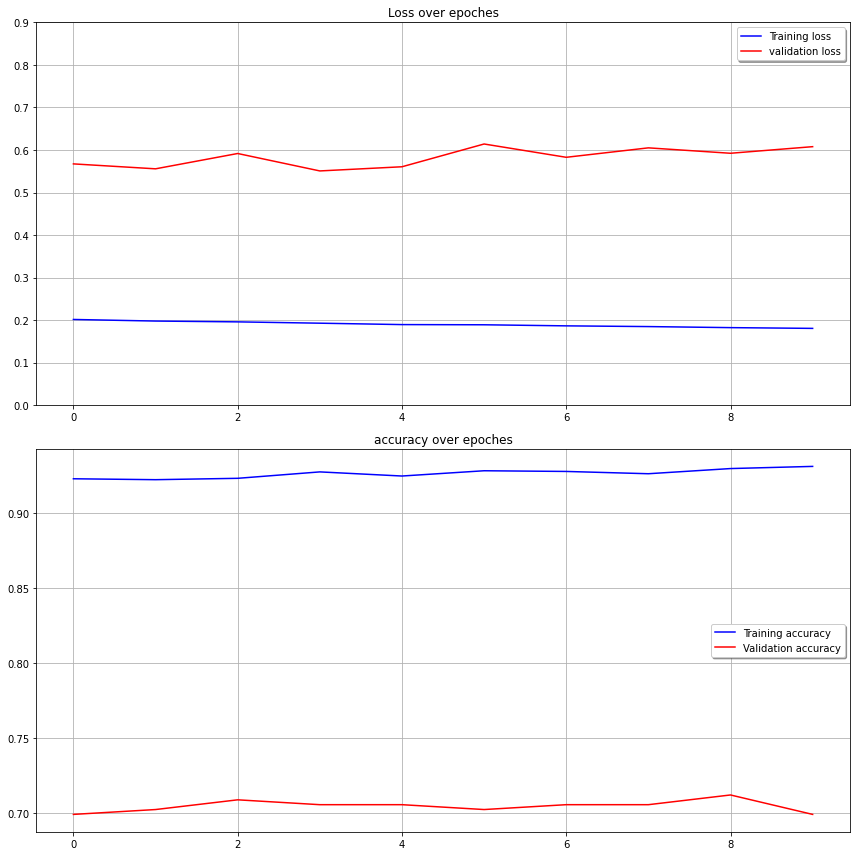

In [ ]:
plot_loss_and_accuracy_over_epoches(history, 10)

## Comments
* We can see the model begins to overfit after 11 epochs.

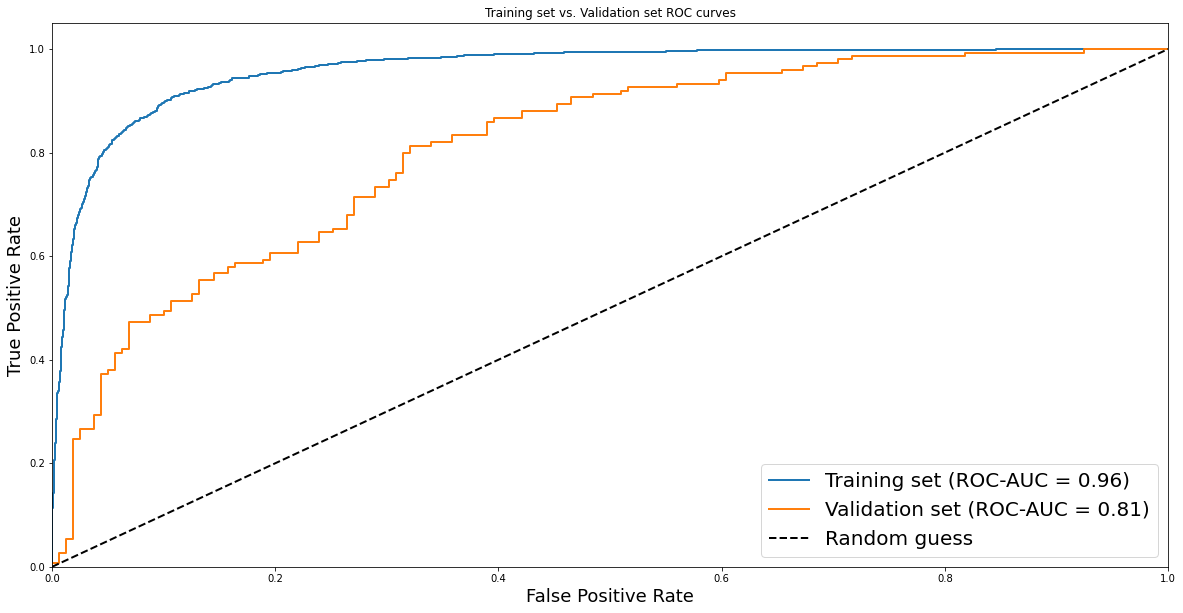

In [ ]:
# Plot ROC curve and show ROC-AUC results of the training and validation sets. 
pred = [model.predict(train_x), model.predict(val_x)]
actual = [train_y, val_y]
stats(pred, actual)


## Ideas of next steps
* Data augmentation
* Bicoherence and Biphase
* Balancing the data (Oversampling or undersampling ?)
* Deeper usage of the auxiliary dataset
* Transfer learning [Transfer learning with convolutional neural networks for moving target classification with micro-Doppler radar spectrograms](https://ieeexplore.ieee.org/document/8396184)
* General research on CNNs